# INICIALIZAÇÃO

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline 
from sklearn.linear_model import LinearRegression

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

data = pd.read_csv("eleicoes_2006_a_2010.csv")

In [25]:
#exibindo os dados originais
data.head()

,ano,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos/comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,quantidade_despesas,...,"ocupacao_TÉCNICO DE OBRAS CIVIS, ESTRADAS, SANEAMENTO E ASSEMELHADOS",ocupacao_TÉCNICO EM AGRONOMIA E AGRIMENSURA,ocupacao_TÉCNICO EM EDIFICAÇÕES,ocupacao_TÉCNICO EM INFORMÁTICA,ocupacao_VENDEDOR DE COMÉRCIO VAREJISTA E ATACADISTA,"ocupacao_VENDEDOR PRACISTA, REPRESENTANTE, CAIXEIRO-VIAJANTE E ASSEMELHADOS",ocupacao_VEREADOR,ocupacao_VETERINÁRIO,ocupacao_VIGILANTE,ocupacao_ZOOTECNISTA
0,2006,1.945910,1.945910,9.717218,7.925760,8.324939,9.105091,8.748464,7.170888,2.708050,...,0,0,0,0,0,0,1,0,0,0
1,2006,2.639057,2.639057,10.035699,7.471276,8.798757,9.615872,6.908755,5.308268,3.218876,...,0,0,0,0,0,0,0,0,0,0
2,2006,2.890372,2.833213,11.905790,9.133303,7.719130,10.438547,11.038461,10.993748,4.820282,...,0,0,0,0,0,0,0,0,0,0
3,2006,1.945910,1.945910,8.007074,6.216979,8.324939,7.048386,7.004991,6.621406,2.197225,...,0,0,0,0,0,0,0,0,0,0
4,2006,3.891820,3.891820,9.634619,7.466020,8.324939,10.837206,10.011960,11.141035,4.897840,...,0,0,0,0,0,0,0,0,0,0


# PRÉ-PROCESSAMENTO

## Normalizando as características

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13112CF0>,
      dtype=object)

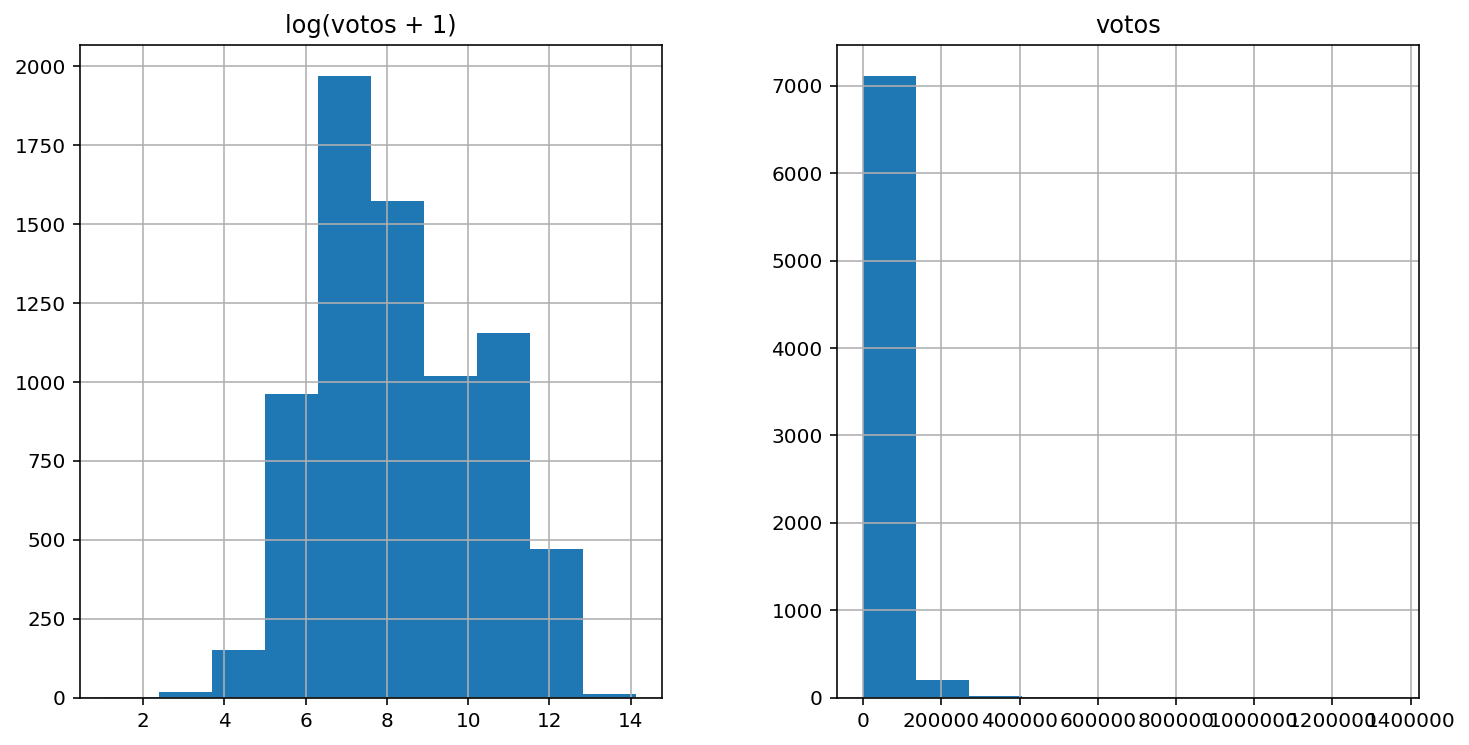

In [4]:
#Analise por meio de histogramas o enviesamento da variável 'votos' com relação ao log+1 dela 
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0);
votos = pd.DataFrame({"votos":data["votos"], "log(votos + 1)":np.log1p(data["votos"])});
votos.hist()

In [5]:
#Conforme observado, a variável estava enviesada, com isso, foi atualizada pelo valor do log+1 dela
data["votos"] = np.log1p(data["votos"])

#Nesse momento, todos as variáveis são atualizadas pelo log+1 delas com relação ao nível de skewness delas
numeric_feats = data.dtypes[data.dtypes != "object"].index

skewed_feats = data[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

data[skewed_feats] = np.log1p(data[skewed_feats])

## Alterando variáveis categóricas

In [6]:
#removendo coluna 'nomes' e 'sequencial_candidato' para reduzir dimensões da matriz e por considerar que não são influenciadores
data = data.drop(["nome"],axis=1)
data = data.drop(["sequencial_candidato"],axis=1)

data = pd.get_dummies(data)

## Preenchendo cada "NA" com as médias de suas respectivas variáveis

In [7]:
data = data.fillna(data.mean())

# REALIZAÇÃO DOS EXPERIMENTOS

In [29]:
#Dividindo os conjuntos de dados em treino e teste
x_train = data.loc[:,'ano':'ocupacao_ZOOTECNISTA']
y_train = data.votos

In [ ]:
#Testes com regressão linear multipla de grau 10, sem regularização
model = make_pipeline(PolynomialFeatures(10),LinearRegression()) 
model.fit(x_train,y_train)

In [30]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model,x_train,y_train):
    rmse= np.sqrt(-cross_val_score(model, x_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

Text(0, 0.5, 'rmse')

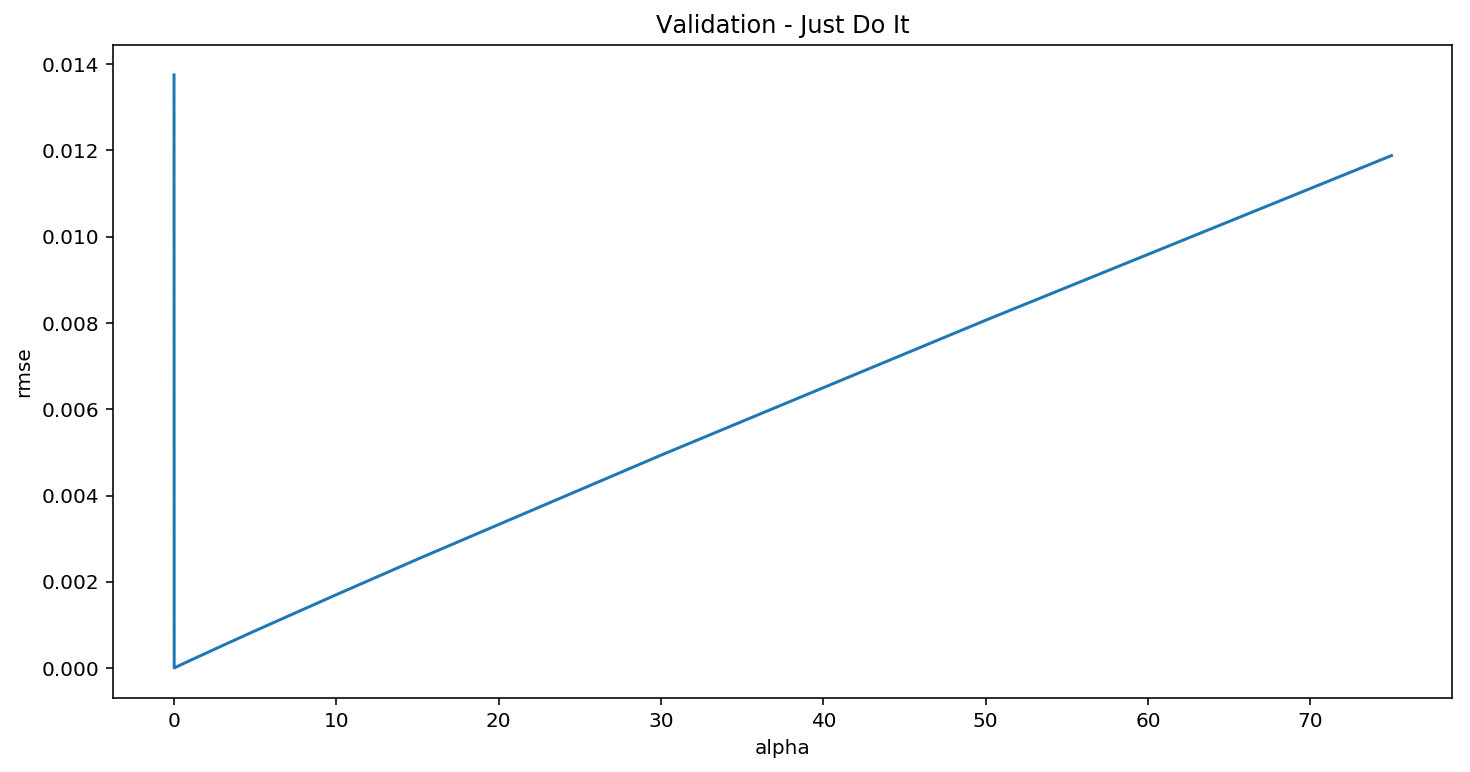

In [31]:
model_ridge = Ridge()

alphas = [0,0.01,0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha),x_train,y_train).mean() 
            for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")


In [10]:
cv_ridge.min()

2.153966682816458e-05

In [21]:
model_lasso = LassoCV()

alphas = [0.05, 0.1, 1]
cv_lasso = [rmse_cv(LassoCV(alpha = alpha),X_train,y_train).mean()
            for alpha in alphas]

cv_lasso.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

TypeError: __init__() got an unexpected keyword argument 'alpha'